# Water Quality Model

## dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## dataset

In [2]:
# importing the dataset
data = pd.read_csv("../dataset/water_data.csv")
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
data.shape

(3276, 10)

In [4]:
# checking potability distr
data["Potability"].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

In [5]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [7]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [8]:
data.duplicated().sum()

np.int64(0)

### cleaning the data

In [9]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [10]:
# mean and median for the sulfate entry
print(
    data["Sulfate"].median(),
    data["Sulfate"].mean()
)

333.073545745888 333.7757766108135


In [11]:
# mean and median for the ph entry
print(
    data["ph"].median(),
    data["ph"].mean()
)

7.036752103833548 7.080794504276835


In [12]:
# mean and median for trihalomethanes entry
print(
    data["Trihalomethanes"].median(),
    data["Trihalomethanes"].mean()
)

66.62248509808484 66.39629294676803


In [13]:
# filling the missing values with the means
cols_with_na = data.columns[data.isnull().any()].tolist()
cols_with_na

['ph', 'Sulfate', 'Trihalomethanes']

In [14]:
# filling with means
for column in cols_with_na:
    data[column] = data[column].fillna(data[column].mean())

data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [15]:
data.shape

(3276, 10)

In [16]:
data.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,7.080795,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


## exploratory data analysis

In [17]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.469956,32.879761,8768.570828,1.583085,36.142612,80.824064,3.308162,15.769881,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.080795,196.967627,20927.833607,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


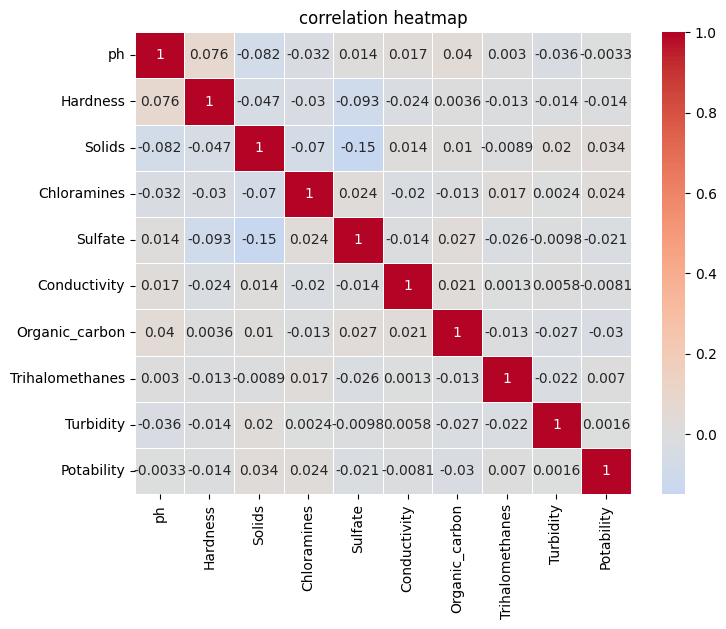

In [18]:
# correlation matrix heatmap
corr_matrix = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("correlation heatmap")
plt.show()

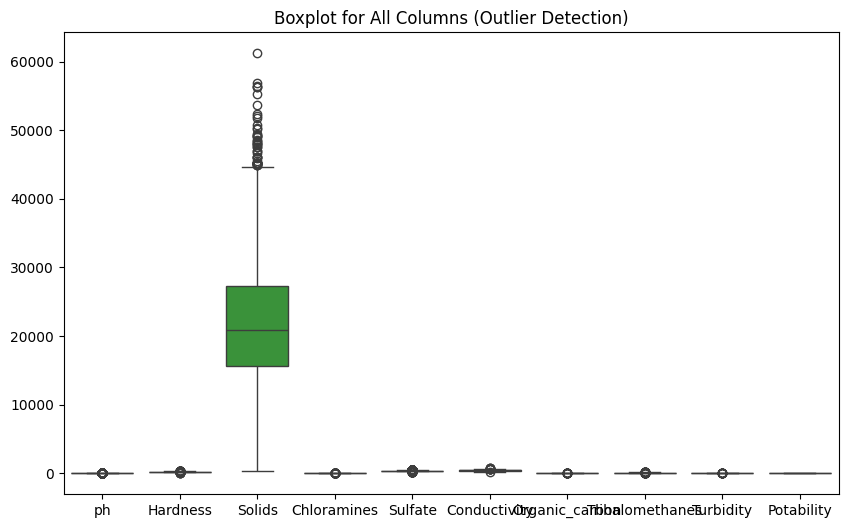

In [19]:
# outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=data, orient="v")
plt.title("Boxplot for All Columns (Outlier Detection)")
plt.show()


In [20]:
# boxplot function
def features_boxplots(data, feature):
    plt.figure(figsize=(6,4))
    sns.boxplot(y=data[feature])
    plt.title(f"boxplot for {feature}")
    plt.show()

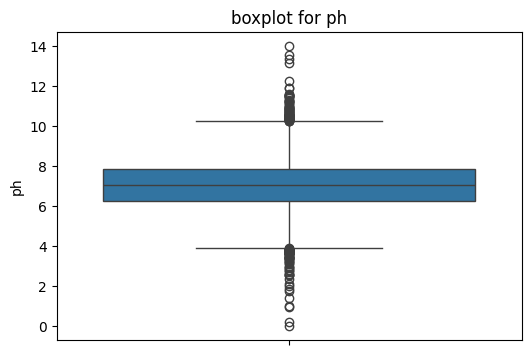

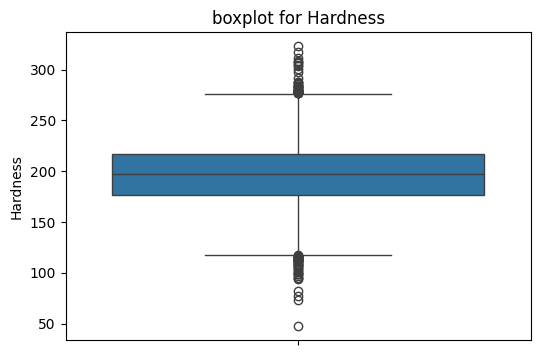

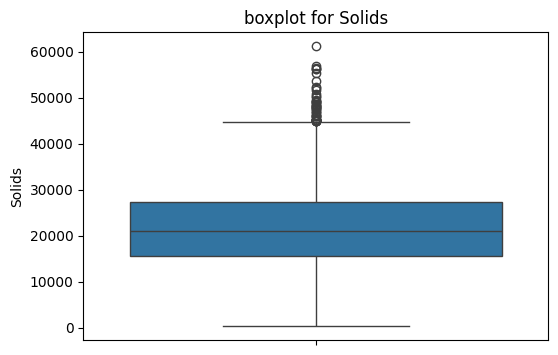

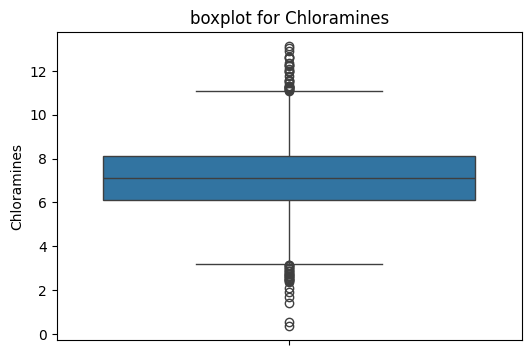

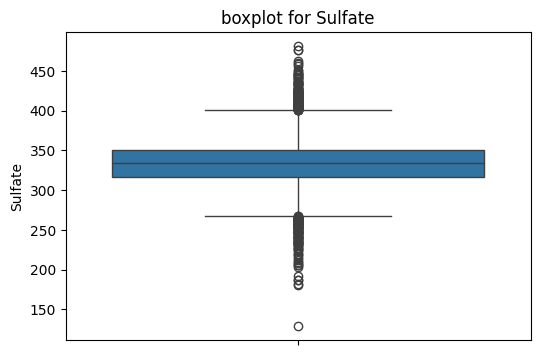

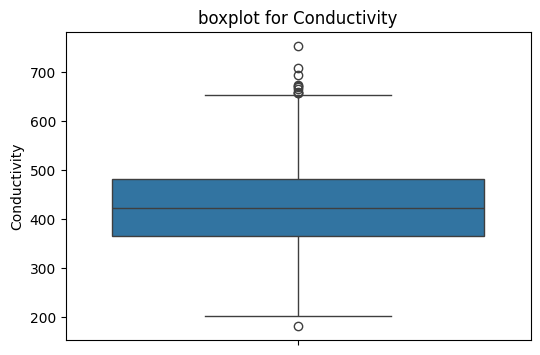

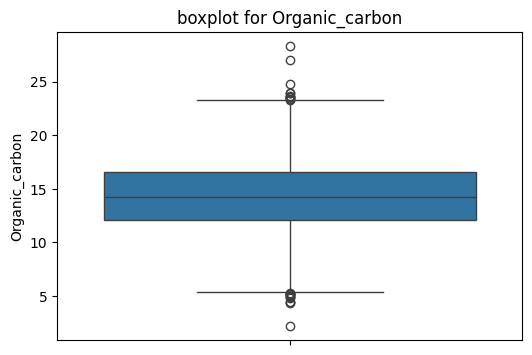

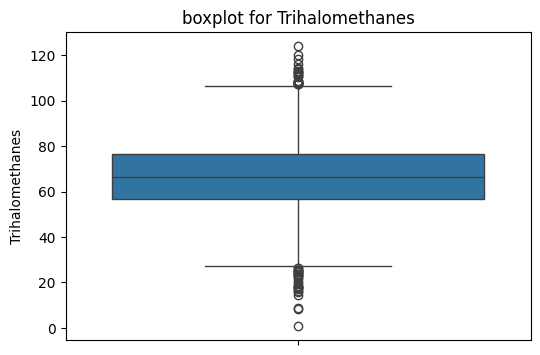

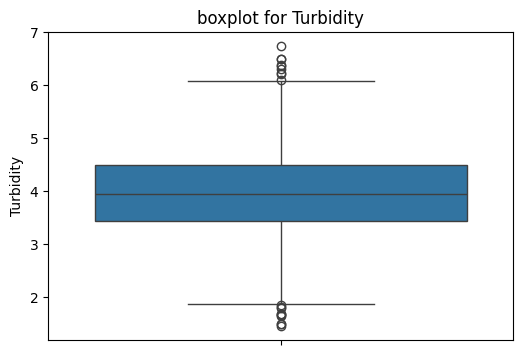

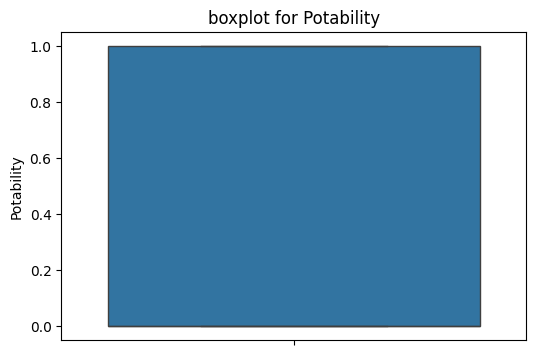

In [21]:
# indivindual features boxplots
features = data.columns.tolist()
for feature in features:
    features_boxplots(data, feature)

In [22]:
# function to get outliers
def get_outliers(data):
    outlier_dict = {}
    features = data.drop("Potability", axis=1).columns.tolist()
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = data[
            (data[feature] < lower) |
            (data[feature] > upper)
        ][feature]
        outlier_dict[feature] = outliers.tolist()
    return outlier_dict

In [25]:
# getting outliers
outliers = get_outliers(data)
print("outliers:\n", len(outliers))
print("\n")

# outliers per column
for feature, outs in outliers.items():
    print(
        feature, "outliers:\n", outs if outs else "None"
    )
    print(len(outs))
    print("-"*50)

outliers:
 9


ph outliers:
 [3.71608007538699, 11.180284470721592, 3.4450618643852127, 10.43329098280438, 3.641629777473381, 10.68296642580598, 10.560744636218196, 3.514545528745279, 3.72250048593372, 1.844538366498842, 2.612035914817261, 3.388090610523891, 10.308477656813704, 11.180694664461903, 3.719791644371925, 11.26782838471403, 3.664710561719395, 13.175401724233025, 10.761897799889317, 10.356118827208377, 3.882631081313793, 11.301793996392291, 3.657123132566738, 3.551579176967154, 2.798549098862777, 10.272444272154384, 10.46450247726032, 10.316400384553162, 3.841205038045167, 3.41035967073924, 10.509668629307154, 3.623165848258656, 1.757037115490783, 3.681076270548827, 3.633162828862528, 10.26843050116335, 0.2274990502021987, 3.4264503676355647, 10.53809844277246, 11.89807802974039, 10.268414718941344, 10.90507641006552, 0.9899122128791388, 10.695532491586295, 10.632909606071516, 10.282067974894762, 10.678056255643256, 10.386132934434618, 10.811289500397242, 10.581385987628256, 

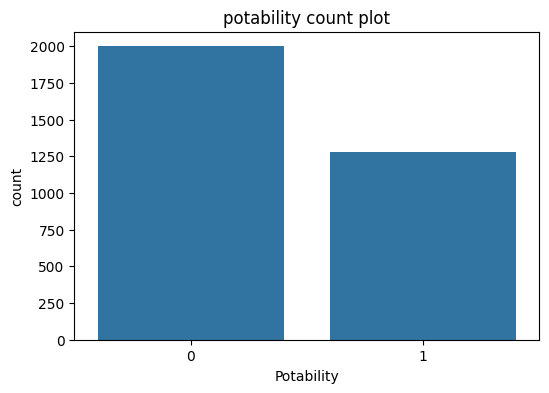

In [28]:
# potability countplot
plt.figure(figsize=(6, 4))
sns.countplot(x="Potability", data=data)
plt.title("potability count plot")
plt.show()